In [3]:
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import nibabel as nib
from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import scipy.integrate as integrate
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
warnings.filterwarnings("ignore")

In [4]:
# Data loading
t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_data()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_data()
# Slice of the Nifti image
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]

In [5]:
# Flat the vector
t1 = t1_slice.flatten().astype(np.float16)
t2 = t2_slice.flatten().astype(np.float16)

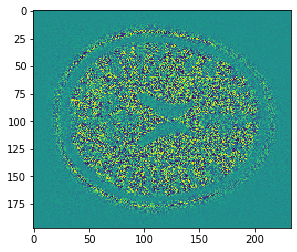

In [14]:
plt.imshow(t1.astype(np.float32) - t1_slice)

In [16]:
np.min(t1.astype(np.float32) - t1_slice)

-0.031243143719621003

In [9]:
t1.dtype

dtype('float16')

In [4]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

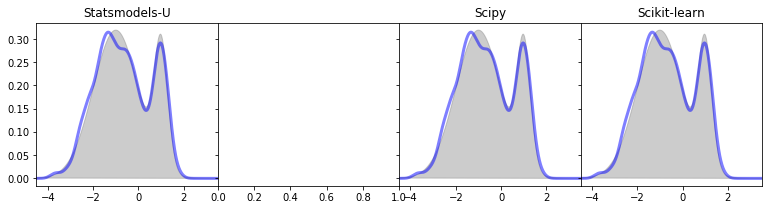

In [5]:
# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    try:
        pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
        ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
        ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
        ax[i].set_title(kde_funcnames[i])
        ax[i].set_xlim(-4.5, 3.5)
    except:
        continue
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")

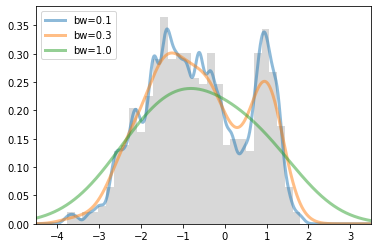

In [6]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(-4.5, 3.5)
ax.legend(loc='upper left')
plt.show()

In [7]:
dens_u = KDEMultivariate(data=[t1,t2],
                         var_type='cc', bw='normal_reference')

In [8]:
kde = KernelDensity(kernel='epanechnikov', algorithm='ball_tree',bandwidth=0.2).fit(np.array([t1,t2]).transpose())

In [ ]:
# Integration : kernel density
# copulas
# How do the similarities compare
# Test in different images
# What's the distance telling about the relationship of the images
# Animation of blurring
# both images

In [9]:
from copulas.multivariate import GaussianMultivariate
copula = GaussianMultivariate()

In [ ]:
copula.fit(np.array([t1,t2]))

In [ ]:
XY[1,:]

In [ ]:
n = XY.shape[0] # number of samples

In [ ]:
np.sort(XY)

In [ ]:
a = t1 <= np.arange(n).reshape(1,n)

In [ ]:
B = t2 <= np.arange(n).reshape(n,1)

In [ ]:
(a + B).shape

In [ ]:
np.where((a+B), 1, np.nan)

In [14]:
im_1 = pydicom.dcmread('im_1.dcm').pixel_array.flatten()
im_2 = pydicom.dcmread('im_2.dcm').pixel_array.flatten()

In [3]:
im_1.shape

(262144,)

In [18]:
XY = np.vstack((t1,t2)).T
n = XY.shape[0]

In [32]:
XY[:,0]

array([0.30434677, 0.47134305, 0.37293453, ..., 1.34210939, 1.40920611,
       1.09161496])

In [20]:
e_copula = np.zeros((n,n))

In [ ]:
from tqdm import tqdm

In [ ]:
for i in tqdm(range(n)):
    for j in range(n):
        c = np.sum(np.where( (np.sum(np.where((XY <= [[i,j]]), 1, 0), axis = 1)) == 2, 1, 0))
        e_copula[i,j] = c/n

In [30]:
i_index = np.arange(n)
j_index = np.arange(n)

In [31]:
(XY[:,0] <= i_index)
#(XY <= j_index) 

array([False,  True,  True, ...,  True,  True,  True])

In [ ]:
e_copula.shape

In [36]:
_x = [1,5,7]
_y = [5,1,4]

In [74]:
_xy = np.vstack((_x,_y)).T.reshape(n,2,1,1)

In [37]:
_copu = np.zeros((3,3))

In [40]:
_copu[0,0] = 0
_copu[0,1] = 0
_copu[0,2] = 1
_copu[1,0] = 1
_copu[1,1] = 1
_copu[1,2] = 2
_copu[2,0] = 1
_copu[2,1] = 2
_copu[2,2] = 3

In [44]:
n = 3

In [54]:
_xy_sorted = np.vstack((np.sort(_x), np.sort(_y))).T.reshape(n,2,1)

In [69]:
_xy_sorted = np.stack((
    np.sort(_x) + np.zeros((n,n)),
    (np.sort(_y) + np.zeros((n,n))).T
)).reshape(1,2,n,n)

In [77]:
_xy_sorted.shape

(1, 2, 3, 3)

In [82]:
np.all(_xy <= _xy_sorted, axis = 1).sum(axis = 0).T

array([[0, 0, 1],
       [1, 1, 2],
       [1, 2, 3]])

In [81]:
_copu

array([[0., 0., 1.],
       [1., 1., 2.],
       [1., 2., 3.]])

In [18]:
def em_copula(x,y):
    n = len(x)
    _xy = np.vstack((x,y)).T.reshape(n,2,1,1)
    _xy_sorted = np.stack((
        np.sort(x) + np.zeros((n,n)),
        (np.sort(y) + np.zeros((n,n))).T
    )).reshape(1,2,n,n)
    e = np.all(_xy <= _xy_sorted, axis = 1).sum(axis = 0).T
    return e

In [91]:
x1 = [10,4,6,8]
x2 = [5,1,3,9]
ee = np.array([[1,1,1,1],
              [1,2,2,2],
              [1,2,2,3],
              [1,2,3,4]])

In [ ]:
em_copula(t1,t2)

In [ ]:
XY.shape

In [ ]:
im_1.shape

In [33]:
from scipy.linalg import cholesky

In [47]:
cm = np.array([[1,0.9,],[0.9,1]])
L = cholesky(cm)
n = 100
mu = np.zeros(len(calib_correl_matrix))
Y = np.random.multivariate_normal(mu, cm, n)
df = 30
S = chi2.rvs(df)
Z = np.sqrt(df/S)*L@Y.T
U = t.ppf(df, Z)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma, chi2, t

#Define number of sampling points
n_samples = len(t1)
df = 30

calib_correl_matrix = np.array([[1,0.4,],[0.4,1]]) #I just took a bivariate correlation matrix here
mu = np.zeros(len(calib_correl_matrix))
s = chi2.rvs(df, size=n_samples)[:, np.newaxis]
#s = invgamma.pdf(df/2,df/2) 
Z = np.random.multivariate_normal(mu, calib_correl_matrix,n_samples)
X = np.sqrt(df/s)*Z #chi-square method
#X = np.sqrt(s)*Z #inverse gamma method

U = t.cdf(X,df)

In [ ]:
U_pd = pd.DataFrame(U)
fig = plt.gcf()
fig.set_size_inches(14.5, 10.5)
pd.plotting.scatter_matrix(U_pd, figsize=(14,10), diagonal = 'kde')
plt.show()

In [ ]:
U